# Running ns-3 Simulation Campaigns with SEM

This example shows how you can use SEM to manage an ns-3 simulation campaign. We
will be working with the ``wifi-multi-tos`` simulation script: this ns-3 program
creates a WiFi network, measures the aggregate throughput and prints it out to
the standard output. 

## Creating the simulation campaign object

First of all, let's import some relevant libraries. We will be using ``sem`` to
run our simulations and parse the outputs, and ``matplotlib`` and ``seaborn`` to
plot the results. We also import 

In [1]:
import sem
import pprint
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")


Most of our interaction with ``sem`` will happen through an object of type
``CampaignManager``. When we create our campaign, we need to tell ``sem`` where
to find our ns-3 installation, what script we want to run, and where it should
save our results.

In [2]:
ns_path = 'ns-3'
script = 'wifi-multi-tos'
campaign_dir = "results"
campaign = sem.CampaignManager.new(ns_path, script, campaign_dir, overwrite=True)


Building ns-3: 100%|██████████| 1675/1675 [13:23<00:00,  1.08s/file]


At time of campaign creation, ``sem`` compiles ns-3, asks the ns-3 script we
want to use for its command line parameters, and looks at the hash of the commit
the ns-3 repository is currently at. This data is saved and printed out when we
inspect the campaign object.

In [3]:
print(campaign)


--- Campaign info ---
script: wifi-multi-tos
params: {'nWifi': 4.0, 'distance': 1.0, 'simulationTime': 10.0, 'useRts': False, 'mcs': 7.0, 'channelWidth': None, 'useShortGuardInterval': False}
HEAD: 2d7f24b9adaf5dadf29c15d7237a96b43f77ef27
Runner type: <class 'sem.parallelrunner.ParallelRunner'>
-----------


## Running simulations

Now that we created our simulation campaign object, we can use it to run some
simulations. In order to do this, we need to specify what parameter combinations
we are interested in running. The ``wifi-multi-tos`` script supports the
following command line parameters:

- ``nWifi``: Number of STAs to simulate
- ``distance``: Distance of STAs from the AP
- ``useRts``: Whether to enable RTS/CTS
- ``useShortGuardInterval``: Whether to use the short guard interval
- ``mcs``: Modulation Coding Scheme to use
- ``channelWidth``: Channel Width in MHz
- ``simulationTime``:  How long to simulate for

Say we are interested in seeing how a certain MCS is affected by the distance
between the STA and the AP. In this case, we might want to run simulations with
different values of the ``mcs`` and ``distance`` parameters. To do this, we
create a Python dictionary where the keys are the name of the parameters, and
the values are lists of parameter values. When we pass this dictionary to our
``campaign`` object's ``run_missing_simulations`` function, ``sem`` will run
simulations for each combination of the specified parameter space.

We also create a ``runs`` variable to specify how many randomized experiments we
want ``sem`` to perform for each parameter combination.


In [4]:
params = {
    'nWifi': [1], 
    'distance': list(range(0, 80, 10)),
    'useRts': [True],  
    'useShortGuardInterval': [True],  
    'mcs': list(range(0, 8, 2)),  
    'channelWidth': [20],  
    'simulationTime': [4],  
}
runs = 2

campaign.run_missing_simulations(params, runs=runs)


Running simulations: 100%|██████████| 64/64 [01:10<00:00,  1.10s/simulation]


## Viewing results

Results are now saved in the campaign object's database. We can access them
through the campaign's database object, which offers a ``get_complete_results``
function:


In [5]:
print("There are %s results in the database\n" % len(list(campaign.db.get_complete_results())))
example_result = next(campaign.db.get_complete_results())
print("This is an example result:\n")
pprint.pprint(example_result)

There are 64 results in the database

This is an example result:

{'meta': {'elapsed_time': 1.6430883407592773,
          'exitcode': 0,
          'id': 'ceb445bf-41a1-44fc-9cde-d1f96ee59864'},
 'output': {'stderr': '', 'stdout': 'Aggregated throughput: 0 Mbit/s\n'},
 'params': {'RngRun': 51,
            'channelWidth': 20,
            'distance': 60,
            'mcs': 2,
            'nWifi': 1,
            'simulationTime': 4,
            'useRts': True,
            'useShortGuardInterval': True}}


We can see that there are 64 results in the database, corresponding to the
simulations we ran earlier. A single result is simply a dictionary, with three
keys:
- ``meta``, whose value is a dictionary containing information on the simulation execution
- ``output``, whose value is a dictionary containing a list of files created by the simulation, in addition to entries containing stdout and stderr
- ``params``, whose value is the parameter specification that was used to obtain this result

We can thus see the output produced by the simulation easily:


In [6]:
print(example_result['output']['stdout'])


Aggregated throughput: 0 Mbit/s



If we are interested in running one of such results manually, using waf from our
ns-3 installation, ``sem`` provides a function that outputs the appropriate
command automatically:


In [7]:
waf_command = sem.utils.get_command_from_result(script, example_result)
print("Use this command to reproduce the example result:\n%s" % waf_command)

waf_command_debug = sem.utils.get_command_from_result(script, example_result, debug=True)
print("Or obtain a debug command by setting the debug flag to true:\n%s" % waf_command_debug)


Use this command to reproduce the example result:
python3 waf --run "wifi-multi-tos --nWifi=1 --distance=60 --useRts=True --useShortGuardInterval=True --mcs=2 --channelWidth=20 --simulationTime=4 --RngRun=51"
Or obtain a debug command by setting the debug flag to true:
python3 waf --run wifi-multi-tos --command-template="gdb --args %s --nWifi=1 --distance=60 --useRts=True --useShortGuardInterval=True --mcs=2 --channelWidth=20 --simulationTime=4 --RngRun=51"


## Exporting and plotting results
Now that the results of the simulations we are interested in running are saved
in the database, it's time to obtain some plots. In order to do this, we have to
transform strings like:


In [8]:
print(example_result['output']['stdout'])


Aggregated throughput: 0 Mbit/s



into values we can plot. In this case, since we are interested in the aggregate
throughput, it will be enough to get the second-to-last word of the stdout
string and convert it to a float. We can do this with a function that takes the 
result as input and outputs the measured throughput. For reasons we will explain
later, let's have this function return a list containing our throughput:


In [9]:
def get_average_throughput(result):
    return [float(result['output']['stdout'].split(" ")[-2])]


We can test the function is working properly on our example result:

In [10]:
get_average_throughput(example_result)


[0.0]

Looks ok! ``sem`` can accept functions defined like this, and use them on all
the available results to produce neatly formatted and easy-to-use data
structures. Let's create a Pandas DataFrame using the
``get_results_as_dataframe`` function:


In [11]:
# Tell SEM how to label the output of the function
throughput_labels = ['Throughput']

# Use the parsing function to create a Pandas dataframe
results = campaign.get_results_as_dataframe(get_average_throughput,
                                            throughput_labels,
                                            params=params,
                                            drop_columns=True)


Let's now inspect the ``results`` DataArray:

In [12]:
print(results)


    distance  mcs  RngRun  Throughput
0          0    0       1     6.06758
1          0    0       0     6.05875
2          0    2       2    16.35100
3          0    2       3    16.20970
4          0    4       4    28.35370
..       ...  ...     ...         ...
59        70    2      58     0.00000
60        70    4      61     0.00000
61        70    4      60     0.00000
62        70    6      62     0.00000
63        70    6      63     0.00000

[64 rows x 4 columns]


Now that we have our results collected in such a data structure, plotting comes
very naturally using ``seaborn``:

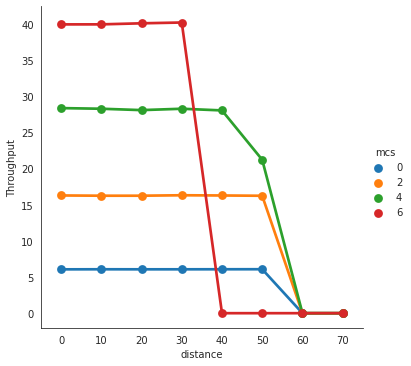

In [13]:
sns.catplot(data=results,
            x='distance',
            y='Throughput',
            hue='mcs',
            kind='point')
plt.show()

## More plot examples

Say we are now interested in seeing the effect of the ``useRts`` and ``useShortGuardInterval`` parameters. We just need to run some additional simulations and re-export results:

In [14]:
params = {
    'nWifi': [1], 
    'distance': [10],
    'useRts': [False, True],  
    'useShortGuardInterval': [False, True],  
    'mcs': list(range(0, 8, 2)),  
    'channelWidth': [20],  
    'simulationTime': [4],  
}
runs = 2

campaign.run_missing_simulations(params, runs=runs)

Running simulations: 100%|██████████| 24/24 [00:36<00:00,  1.51s/simulation]


``sem`` will only perform the necessary simulations that have not already been executed to explore the new parameter space. Now, let's re-use the previous parsing function to extract the throughput for the new results:

In [15]:
# Use the parsing function to create a Pandas dataframe
results = campaign.get_results_as_dataframe(get_average_throughput,
                                            throughput_labels,
                                            params=params,
                                            drop_columns=True)
print(results)

    useRts  useShortGuardInterval  mcs  RngRun  Throughput
0    False                  False    0      65     5.76141
1    False                  False    0      64     5.76730
2    False                  False    2      67    16.30980
3    False                  False    2      66    16.19790
4    False                  False    4      69    30.76480
5    False                  False    4      68    30.91200
6    False                  False    6      71    43.68900
7    False                  False    6      70    42.63800
8    False                   True    0      72     6.42381
9    False                   True    0      73     6.40614
10   False                   True    2      74    18.12030
11   False                   True    2      75    17.97020
12   False                   True    4      76    34.12680
13   False                   True    4      77    33.58220
14   False                   True    6      78    46.94500
15   False                   True    6      79    47.092

As we can see, only 32 results are now parsed by the function, since we specified the parameter space we are interested in when we called ``get_results_as_dataframe``. Now, let's move on to plotting.

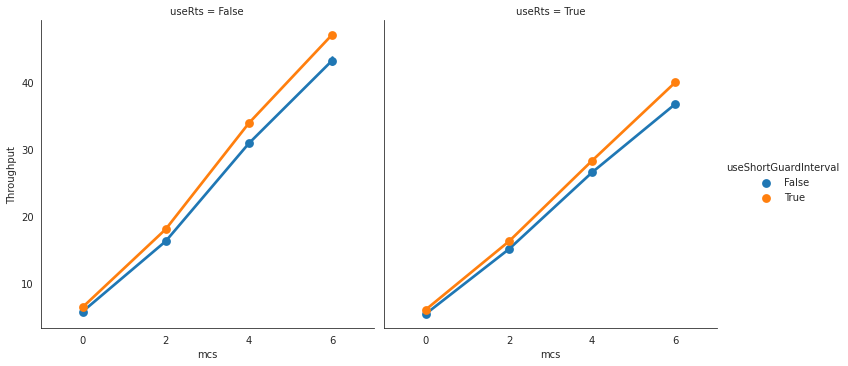

In [16]:
sns.catplot(data=results,
            x='mcs',
            y='Throughput',
            col='useRts',
            hue='useShortGuardInterval',
            kind='point')
plt.show()

Once initial plots are obtained, it's easy to adjust the number of repetitions using the runs argument, and get cleaner results.

Finally, let's see how the number of WiFi devices impacts the distribution of the aggregate throughput:

Running simulations: 100%|██████████| 98/98 [03:31<00:00,  2.16s/simulation]


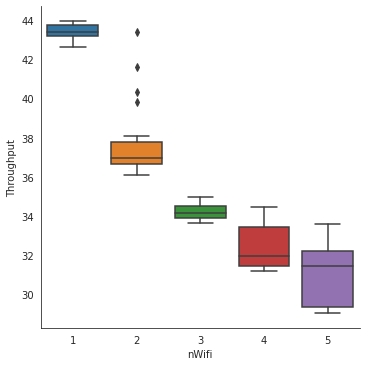

In [17]:
params = {
    'nWifi': list(range(1, 6)), 
    'distance': [10],
    'useRts': [False],  
    'useShortGuardInterval': [False],  
    'mcs': [6],  
    'channelWidth': [20],  
    'simulationTime': [4],  
}
runs = 20

campaign.run_missing_simulations(params, runs=runs)

results = campaign.get_results_as_dataframe(get_average_throughput,
                                            throughput_labels,
                                            params=params,
                                            drop_columns=True)
sns.catplot(data=results,
            x='nWifi',
            y='Throughput',
            kind='box')
plt.show()